In [1]:
import sklearn.datasets
import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
digits = sklearn.datasets.load_digits()

In [3]:
import seaborn as sns
from sklearn.manifold import TSNE

In [4]:
tsne_map = TSNE().fit_transform(digits.data)

/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [5]:
symmetric_graph, _, _ = umap.umap_.fuzzy_simplicial_set(digits.data, n_neighbors=15, metric="euclidean", random_state=42)
# symmetric_graph[np.arange(symmetric_graph.shape[0]), np.arange(symmetric_graph.shape[0])] = 1.0
umap_graph = symmetric_graph.copy()
directed_graph, _, _ = umap.umap_.fuzzy_simplicial_set(digits.data, n_neighbors=15, metric="euclidean", random_state=42, apply_set_operations=False)
directed_graph = directed_graph.tocsr()

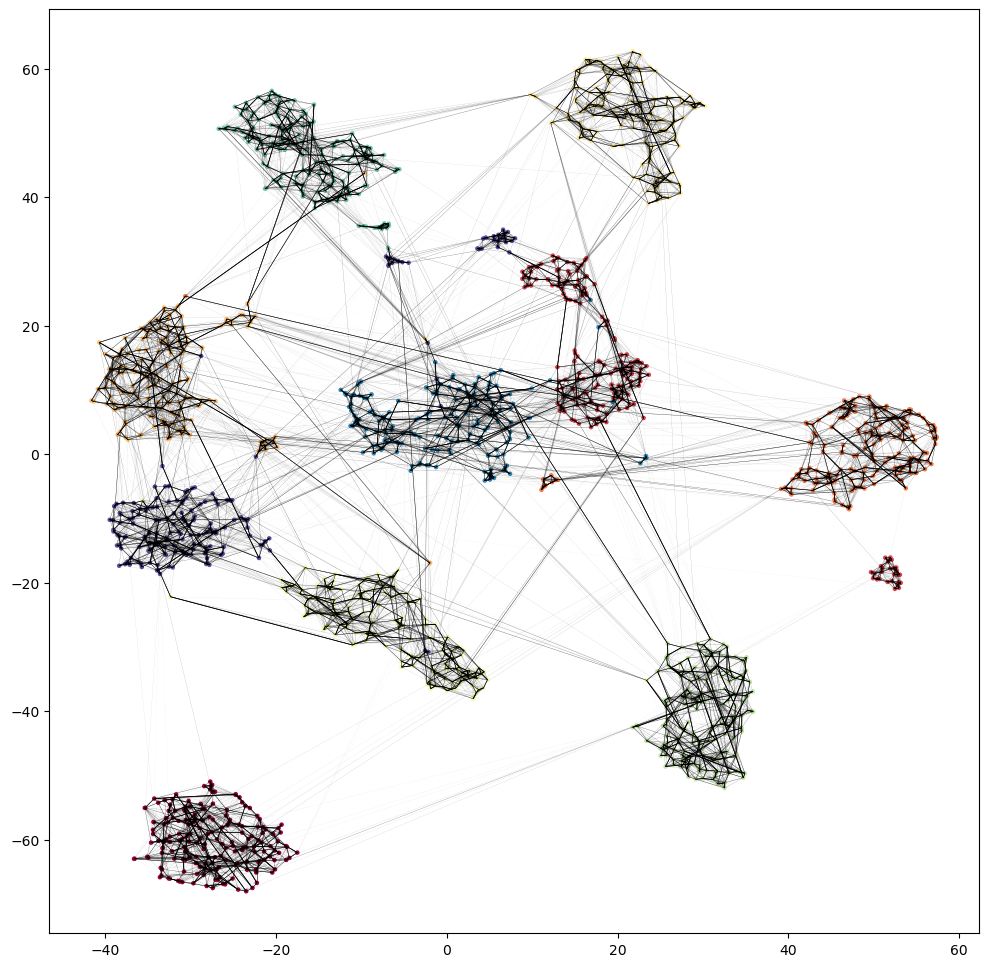

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = umap_graph.tocoo()
edges = LineCollection(
    np.dstack([tsne_map[coo_umap_graph.row], tsne_map[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=0.5 * coo_umap_graph.data, 
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), coo_umap_graph.data]).T,
    zorder=3
)
ax.add_collection(edges)
# for idx in range(coo_umap_graph.row.shape[0]):
#     i, j, weight = coo_umap_graph.row[idx], coo_umap_graph.col[idx], coo_umap_graph.data[idx]
#     ax.plot(map.T[0][[i, j]], map.T[1][[i, j]], lw=weight*0.5, c='k', alpha=weight)
ax.scatter(*tsne_map.T, s=5, c=digits.target, cmap="Spectral")

In [8]:
from sklearn.preprocessing import normalize
import scipy.sparse.csgraph

In [9]:
umap_graph = normalize(directed_graph, norm="l1")
new_graph = umap_graph * umap_graph# + umap_graph
new_graph.setdiag(0)
new_graph = normalize(new_graph, norm="l1")
new_graph.data[new_graph.data < 0.001] = 0.0
new_graph = normalize(new_graph, norm="l1")
new_graph.eliminate_zeros()
new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)
# new_graph = new_graph.maximum(new_graph.T)

for i in range(100):
    new_graph = umap_graph * new_graph# + umap_graph
    # new_graph = new_graph * umap_graph
    new_graph.setdiag(0)
    new_graph = normalize(new_graph, norm="l1")
    new_graph.data[new_graph.data < 0.001] = 0.0
    new_graph = normalize(new_graph, norm="l1")
    new_graph.eliminate_zeros()
    new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)

    # new_graph = new_graph.maximum(new_graph.T)
    
new_graph = new_graph ** 3
new_graph.data[new_graph.data < 0.001] = 0.0
new_graph.eliminate_zeros()

/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = new_graph.tocoo()
edges = LineCollection(
    np.dstack([tsne_map[coo_umap_graph.row], tsne_map[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=coo_umap_graph.data, 
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), coo_umap_graph.data]).T,
    zorder=3
)
ax.add_collection(edges)
ax.scatter(*tsne_map.T, s=5, c=digits.target, cmap="Spectral")

In [738]:
distance_graph = new_graph.copy()
# distance_graph = distance_graph + distance_graph * distance_graph + distance_graph * distance_graph * distance_graph
# distance_graph = distance_graph * distance_graph
print(np.sum(distance_graph.data > 1))
distance_graph.eliminate_zeros()
distance_graph.data = -np.log(distance_graph.data)

0


In [739]:
import hdbscan

In [740]:
if scipy.sparse.csgraph.connected_components(distance_graph)[0] > 1:
    n_components, components = scipy.sparse.csgraph.connected_components(distance_graph)
    rj_labels = np.full(distance_graph.shape[0], -1, dtype=np.int64)
    for i in range(n_components):
        if np.sum(components == i) <= 90:
            subgraph_labels = np.zeros(np.sum(components == i), dtype=np.int64)
        else:
            subgraph = distance_graph[components == i, :][:, components == i]
            subgraph_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30, allow_single_cluster=subgraph.shape[0] < 300).fit_predict(subgraph)
        subgraph_labels[subgraph_labels >= 0] += (rj_labels.max() + 1)
        rj_labels[components == i] = subgraph_labels
else:
    rj_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit_predict(distance_graph)

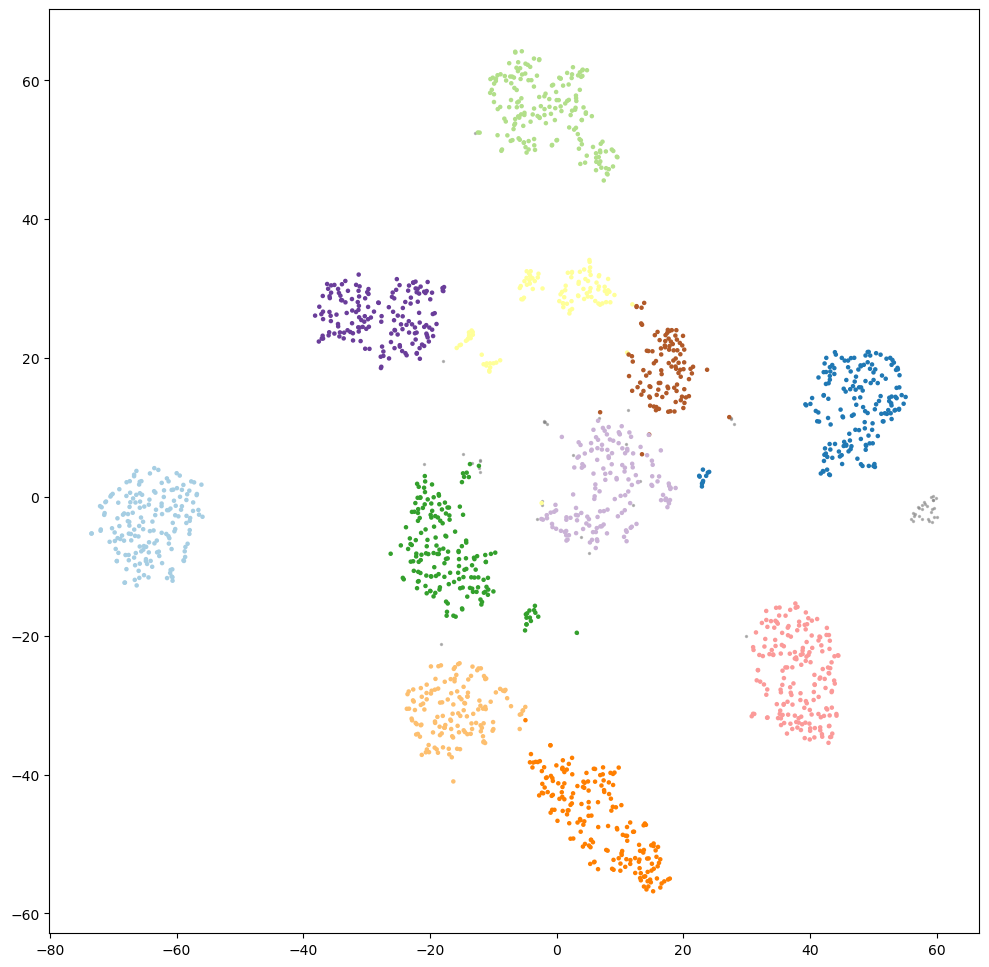

In [741]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(*tsne_map[rj_labels< 0].T, s=2, c="gray", alpha=0.5)
ax.scatter(*tsne_map[rj_labels >= 0].T, s=5, c=rj_labels[rj_labels >= 0], cmap="Paired")

In [742]:
sklearn.metrics.adjusted_rand_score(digits.target, rj_labels)

0.8888344281072982

In [743]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, rj_labels)

0.9073597931629132

In [616]:
uhdb_labels = hdbscan.HDBSCAN().fit_predict(umap.UMAP().fit_transform(digits.data))

In [617]:
sklearn.metrics.adjusted_rand_score(digits.target, uhdb_labels)

0.7794991195761306

In [618]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, uhdb_labels)

0.8388046663513906

In [620]:
clusterer = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit(distance_graph)

<AxesSubplot: ylabel='$\\lambda$ value'>

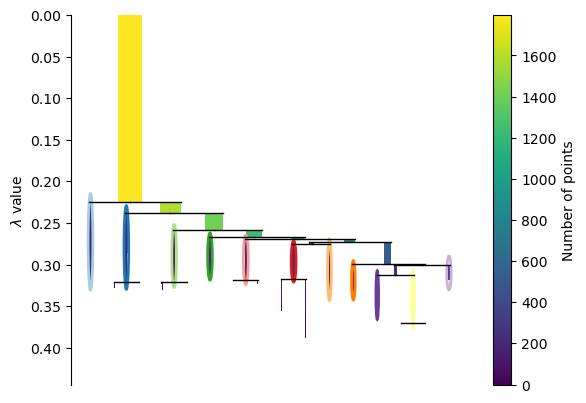

In [627]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette("Paired", np.max(rj_labels) + 1))